# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for XResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [4]:
from nb_new_data_augmentation_adacos_celltype_plategroup import *

In [5]:
import pdb

In [6]:
__version__

'1.0.55'

# 6D image with celltype

In [7]:
class Image6Dct(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor, ctint, pgint): # ct
        self._px = px
        self._logit_px=None
        #self.ct = ct
        self.ctint = ctint
        self.pgint =pgint
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}
    
    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()
        
    def clone(self):
        "Mimic the behavior of torch.clone for `Image` objects."
        return self.__class__(self.px.clone(), self.ctint.clone(), self.pgint.clone()) # self.ct.clone(), 

    @property
    def data(self)->TensorImage:
        "Return this images pixels as a tensor."
        return self.px, self.ctint, self.pgint

In [8]:
def open_image_6Dct(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6Dct,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
    ct = fn.split('/')[1].split('-')[0]
    ctint = torch.tensor(ct2int[ct])
    pgint = torch.tensor(fn2pgint[fn])
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x, ctint, pgint) # ct
    #return cls(x), ctint

In [9]:
df_full_plate_pattern = pd.read_csv('full_dataset_v2_path_plate_groups_only_20190812.csv', index_col=0)

In [10]:
df_full_plate_pattern.head()

,path,plate_pattern
0,train/HEPG2-01/Plate1/B03_s1,0
1,train/HEPG2-01/Plate1/B04_s1,0
2,train/HEPG2-01/Plate1/B05_s1,0
3,train/HEPG2-01/Plate1/B06_s1,0
4,train/HEPG2-01/Plate1/B07_s1,0


In [11]:
fn2pgint = dict(zip(df_full_plate_pattern.path.values, 
                              df_full_plate_pattern.plate_pattern.values))

In [12]:
fn2pgint['train/HEPG2-01/Plate1/B03_s1']

0

In [13]:
# cell types from rcic_v10_inspect_image_data.ipynb "pixel stats"
cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
int2ct = {i: ct for i, ct in enumerate(cts)}
ct2int = {ct: i for i, ct in int2ct.items()}

In [14]:
print(ct2int)
print(int2ct)

{'HEPG2': 0, 'HUVEC': 1, 'RPE': 2, 'U2OS': 3}
{0: 'HEPG2', 1: 'HUVEC', 2: 'RPE', 3: 'U2OS'}


In [15]:
ct = 'train/HEPG2-01/Plate1/B03_s1'.split('/')[1].split('-')[0]; ct

'HEPG2'

In [16]:
ct2int[ct]

0

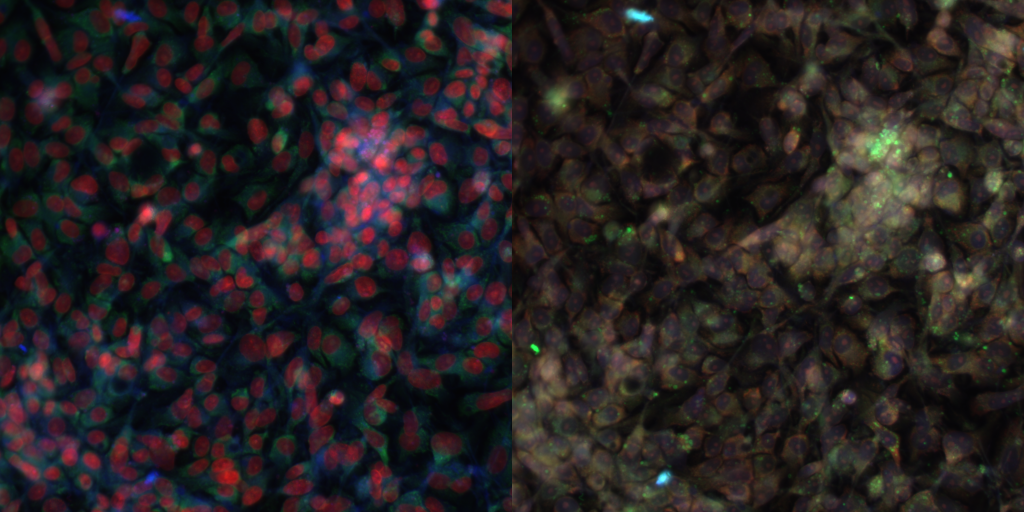

In [17]:
PATH_trunc = 'train/HEPG2-01/Plate1/B03_s1' # path is missing suffix "_w1.png"
open_image_6Dct(PATH_trunc)

In [18]:
img = open_image_6Dct(PATH_trunc)

In [19]:
img.px.shape

torch.Size([6, 512, 512])

In [20]:
img.ctint, img.pgint

(tensor(0), tensor(0))

In [21]:
type(img.ctint), type(img.pgint)

(torch.Tensor, torch.Tensor)

# Dataset setup

In [22]:
class ImageList6Dct(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6Dct(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [23]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset raw files

In [24]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [25]:
df_train.shape

(73030, 5)

In [26]:
df_train.tail()

,path,experiment,sirna,multi,valid
36510,U2OS-03/Plate4/O19_s2,U2OS-03,103,U2OS-03 103,1
36511,U2OS-03/Plate4/O20_s2,U2OS-03,202,U2OS-03 202,1
36512,U2OS-03/Plate4/O21_s2,U2OS-03,824,U2OS-03 824,1
36513,U2OS-03/Plate4/O22_s2,U2OS-03,328,U2OS-03 328,1
36514,U2OS-03/Plate4/O23_s2,U2OS-03,509,U2OS-03 509,1


In [27]:
df_test.tail()

,path,experiment
19892,U2OS-05/Plate4/O19_s2,U2OS-05
19893,U2OS-05/Plate4/O20_s2,U2OS-05
19894,U2OS-05/Plate4/O21_s2,U2OS-05
19895,U2OS-05/Plate4/O22_s2,U2OS-05
19896,U2OS-05/Plate4/O23_s2,U2OS-05


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [28]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [29]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [30]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [32]:
## AdaCos-SE-XResNet50c --> FP32 !!!
# TRAINING
sz, bs = 128, 8*21 # 7576MiB /  7952MiB INCREASE?
#sz, bs = 256, 8*5 # 7341MiB /  7952MiB
#sz, bs = 512, 8 #
# PREDICTION
#sz, bs = 256, 8*25 # 5391MiB /  7952MiB
#sz, bs = 256, 8*40 # 7741MiB /  7952MiB
#sz, bs = 512, 8*5 # 6051MiB /  7952MiB
# DATA AUGM W/O AdaCos
#sz, bs = 128, 8*42 # 7937MiB /  7952MiB
#sz, bs = 256, 8*13 # 
#sz, bs = 512, 8*3 # 


## EfficientNet-B3
#sz, bs = 300, 8 # 4167MiB /  7952MiB
#sz, bs = 300, 8*2 # 78??MiB /  7952MiB // FP16: 4397MiB /  7952MiB
#sz, bs = 300, 8*4 # FP16: 7805MiB /  7952MiB

In [33]:
sz, bs

(128, 168)

In [34]:
# cutout params
#int(sz*0.1), int(sz*0.5)

In [35]:
# normal tfms
#tfms = get_transforms()

In [36]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [36]:
# extended tfms
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75, 
#                      xtra_tfms=[color_augmentation(), 
#                                 cutout(n_holes=(1,4), length=(int(sz*0.1), int(sz*0.5)), p=.5)])

In [37]:
#tfms = [[crop(size=sz, row_pct=(0,1), col_pct=(0,1))], []]

In [38]:
#tfms

In [39]:
# change "crop_pad" from get_transforms to "crop"
# uniform for FIXED cropping
#tfms[0][0] = crop(size=sz, row_pct=uniform(0,1), col_pct=uniform(0,1))
#tfms[1][0] = crop(size=sz, row_pct=uniform(0,1), col_pct=uniform(0,1))

In [40]:
# train crop
#tfms[0][0].kwargs['row_pct'], tfms[0][0].kwargs['col_pct']

In [41]:
# valid crop
#tfms[1][0].kwargs['row_pct'], tfms[1][0].kwargs['col_pct']

In [42]:
#tfms

### Dataset definition

In [37]:
# VALID SPLIT (incl. tfms)
data = (ImageList6Dct.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6Dct.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [ ]:
# FULL DATASET (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_none() # !!!
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [ ]:
# VALID SPLIT PREDICTION (NO tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) 
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(size=sz) # !!!
        .databunch(bs=bs))

In [ ]:
# FULL DATASET PREDICTION (NO tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_none() # !!!
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(size=sz)
        .databunch(bs=bs))

In [34]:
data

ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train

In [ ]:
### CHANGED LINE 65 to:
# nano ~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py

```
~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py in _normalize_batch(b, mean, std, do_x, do_y)
     64     "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
     65     x,y = b
---> 66     mean,std = mean.to(x.device),std.to(x.device)
     67     if do_x: x = normalize(x,mean,std)
     68     if do_y and len(y.shape) == 4: y = normalize(y,mean,std)

AttributeError: 'list' object has no attribute 'device'
```
CHANGED TO:
```
def _normalize_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor, do_x:bool$
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    (x,cint,pgint),y = b
    mean,std = mean.to(x.device),std.to(x.device)
    if do_x: x = normalize(x,mean,std)
    if do_y and len(y.shape) == 4: y = normalize(y,mean,std)
    return (x,cint,pgint),y
```

In [41]:
#data.batch_stats() # DOES NOT WORK?

In [38]:
# From https://github.com/recursionpharma/rxrx1-utils/blob/master/rxrx/main.py
# The mean and stds for each of the channels
GLOBAL_PIXEL_STATS = (np.array([6.74696984, 14.74640167, 10.51260864,
                                10.45369445,  5.49959796, 9.81545561]),
                       np.array([7.95876312, 12.17305868, 5.86172946,
                                 7.83451711, 4.701167, 5.43130431]))

stats_mean = torch.tensor(GLOBAL_PIXEL_STATS[0]/255).float()
stats_var = torch.tensor(GLOBAL_PIXEL_STATS[1]/255).float()

In [39]:
#stats_mean, stats_var

In [40]:
data.normalize([stats_mean, stats_var])

ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train

In [45]:
#data.batch_stats() # DOES NOT WORK?

In [41]:
data.batch_size

40

In [46]:
#data.stats # results is copied below
#[tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
# tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]

In [47]:
#data

In [42]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [43]:
data.train_ds[0]

(Image6Dct (6, 256, 256), Category 513)

In [44]:
#data.classes

In [45]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

In [46]:
data.train_ds[0][0].ctint

tensor(0)

In [47]:
data.train_ds[0][0].pgint

tensor(0)

In [48]:
len(data.train_ds[0][0].data)

3

In [49]:
data.train_ds[0][0].data[0].shape, data.train_ds[0][0].data[1].shape, data.train_ds[0][0].data[2].shape

(torch.Size([6, 256, 256]), torch.Size([]), torch.Size([]))

In [50]:
#data.train_ds[0][0].apply_tfms(crop(size=300, row_pct=(0,1), col_pct=(0,1)))

In [ ]:
### ORIGINAL 512px NO TFMS
data.train_ds[0][0]

### Adversarial full dataset

In [ ]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [ ]:
data_a

In [ ]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

In [ ]:
data_a.batch_size

In [ ]:
data_a.train_ds[0]

In [ ]:
#data_a.classes

In [ ]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

In [ ]:
data_a.train_ds[0][1].data.sum()

In [ ]:
np.where(data_a.train_ds[0][1].data > 0.5)

In [ ]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

In [ ]:
data_a.train_ds[0][0]

In [ ]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## SE-XResNet Feature Extractor

In [39]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [41]:
# from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py#L85
class SE_Module(Module): # change nn.Module to Module

    def __init__(self, channels, reduction=16):
        #super(SE_Module, self).__init__() # not needed?
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [42]:
# fastai resblock combined with SEModule
class SE_ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        #self.convs = nn.Sequential(*layers) # without SEModule
        self.convs = nn.Sequential(*layers, SE_Module(nf))
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [43]:
class SE_XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[SE_ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [44]:
#se_xresnet152f = SE_XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)
se_xresnet50f = SE_XResNetFeature(4, [3,4,6 ,3], c_in=6) #, c_out=1108)

In [45]:
se_xresnet50f(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 2048, 4, 4])

In [46]:
#se_xresnet50f(data.train_ds[0][0].data.unsqueeze(0)).shape

In [47]:
#def set_rg(model=efficientnet_b3f, option=False):
#    for param in model.parameters():
#        param.requires_grad = option
#        
#set_rg()

## ResNet Pre-Head

In [48]:
def resnet_pre_head(concat_pool:bool=True):
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    return nn.Sequential(*layers)

In [49]:
xresnetf_prehead = resnet_pre_head()

In [50]:
xresnetf_prehead

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
)

In [51]:
xresnetf_prehead(torch.randn(2, 2048, 9, 9)).shape

torch.Size([2, 4096])

In [52]:
se_xresnet50fph = nn.Sequential(se_xresnet50f, xresnetf_prehead)

In [53]:
se_xresnet50fph(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 4096])

## CellType Feature Extractor

In [69]:
# basic version
#ctf = nn.Embedding(4,128)

In [70]:
ct2int

{'HEPG2': 0, 'HUVEC': 1, 'RPE': 2, 'U2OS': 3}

In [71]:
#nn.Embedding(4,128)(torch.tensor(ct2int['HUVEC'])).shape

In [72]:
class CellTypeFeatures(nn.Module):
    '''CellType Feature Extractor.'''
    def __init__(self, cell_types=4, emb_sz=128):
        super(CellTypeFeatures, self).__init__()
        self.emb = nn.Embedding(cell_types, emb_sz)
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        # check if we are in CutMix mode:
        if isinstance(xb, tuple):
            x1, x2, λ = xb
            out1 = self.emb(x1)
            out2 = self.emb(x2)
            out = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out = self.emb(xb)
        return out

In [57]:
ctf = CellTypeFeatures()

In [58]:
ctf

CellTypeFeatures(
  (emb): Embedding(4, 128)
)

In [59]:
ctf(torch.tensor(ct2int['HUVEC'])).shape

torch.Size([128])

In [60]:
ctf((torch.tensor(ct2int['HUVEC']), torch.tensor(ct2int['RPE']), 0.9)).shape

torch.Size([128])

## CellType & Plate Group Feature Extractor

In [54]:
class CellTypePlateGroupFeatures(nn.Module):
    '''CellType Feature Extractor.'''
    def __init__(self, cell_types=4, plate_groups=4, emb_sz=128):
        super(CellTypePlateGroupFeatures, self).__init__()
        self.emb_ctint = nn.Embedding(cell_types, emb_sz)
        self.emb_pgint = nn.Embedding(plate_groups, emb_sz)
        
    def forward(self, xb_ctint, xb_pgint, yb=None): # yb=None for training in non-AdaCos mode!
        
        ### CTINT
        # check if we are in CutMix mode:
        if isinstance(xb_ctint, tuple):
            x1, x2, λ = xb_ctint
            out1 = self.emb_ctint(x1)
            out2 = self.emb_ctint(x2)
            out_ctint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_ctint = self.emb_ctint(xb_ctint)
        
        ## PGINT
        # check if we are in CutMix mode:
        if isinstance(xb_pgint, tuple):
            x1, x2, λ = xb_pgint
            out1 = self.emb_pgint(x1)
            out2 = self.emb_pgint(x2)
            out_pgint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_pgint = self.emb_pgint(xb_pgint)
        
        out = torch.cat((out_ctint, out_pgint), dim=-1)
        
        return out

In [55]:
ctf = CellTypePlateGroupFeatures()

In [56]:
ctf

CellTypePlateGroupFeatures(
  (emb_ctint): Embedding(4, 128)
  (emb_pgint): Embedding(4, 128)
)

In [57]:
xb = (torch.tensor(ct2int['HEPG2']),
      torch.tensor(fn2pgint['train/HEPG2-01/Plate1/B03_s1']))

In [58]:
xb

(tensor(0), tensor(0))

In [59]:
ctf(xb[0], xb[1]).shape

torch.Size([256])

In [60]:
torch.randint(4, (2,1))

tensor([[3],
        [2]])

In [61]:
xb = (torch.tensor((1,3)), torch.tensor((1,3)))

In [62]:
xb

(tensor([1, 3]), tensor([1, 3]))

In [63]:
ctf(xb[0], xb[1]).shape

torch.Size([2, 256])

In [64]:
torch.tensor(fn2pgint['train/RPE-01/Plate1/B03_s1'])

tensor(0)

In [65]:
xb = ((torch.tensor(ct2int['HEPG2']), torch.tensor(ct2int['RPE']), 0.9),
      (torch.tensor(fn2pgint['train/HEPG2-01/Plate1/B03_s1']),
       torch.tensor(fn2pgint['train/RPE-01/Plate1/B03_s1']), 0.9))

In [66]:
ctf(xb[0], xb[1]).shape

torch.Size([256])

In [66]:
#class CellTypeFeatures(nn.Module):
#    '''CellType Feature Extractor.'''
#    def __init__(self, cell_types=4, emb_sz=128, lin_ftrs:Optional[Collection[int]]=None, nc=128):
#        super(AdaCosNet, self).__init__()
#        self.emb = nn.Embedding(cell_types, emb_sz)
#        
#        self.lin_ftrs = [emb_sz, 512, 512] if lin_ftrs is None else [emb_sz] + lin_ftrs + [nc]
#
#        
#    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
#
#        return out

## AdaCos-Head

In [67]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                bn_final:bool=False): # concat_pool:bool=True, 
    #nc:int, 
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    
    lin_ftrs = [nf, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    # remove last 512 fc layer to reduce MODEL SIZE ??? ???
    
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    #pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    #layers = [pool, Flatten()]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [68]:
#adacos_head = create_adacos_head(nf=2048+1) 
adacos_head = create_adacos_head(nf=4096+128*2) # se_xresnet50f: 2048*2=4096, ctf: 128*2

In [69]:
adacos_head

Sequential(
  (0): BatchNorm1d(4352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=4352, out_features=512, bias=True)
  (3): ReLU(inplace)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=512, bias=True)
)

In [70]:
#adacos_head

In [71]:
adacos_head(torch.randn(2, 4096+128*2)).shape

torch.Size([2, 512])

In [72]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        
        # for training in non-AdaCos mode (= no yb date in the forward pass):
        if yb is None:
            print('yb = None')
            return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        # ORIGINAL
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #with torch.no_grad():
        #    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
        #    B_avg = torch.sum(B_avg) / xb.size(0)
        #    #print(B_avg)
        #    theta_med = torch.median(theta[one_hot == 1])
        #    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        #    #print(self.s)
            
        # ADAPTED FOR CUTMIX TO GET MIXED SCALE PARAMETER
        with torch.no_grad():
            # FROM nb_new_data_augmentation_adacos2.py LINE 888
            # AND https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py#L40
            if yb.ndim == 2:# and target.shape[-1] >1:
                n_mod_patches = (yb.shape[-1] - 1) // 2
                #c_ = yb[:, 1:n_mod_patches + 1]
                c_ = yb[:, 0:n_mod_patches + 1]
                W_ = yb[:, n_mod_patches + 1:]
                self.s_scaled = []
                
                # this loop is only realdy needed when we have different probabilities inside a batch
                # which we do not have (right now)! So this could be cleaned up, but we leave until
                # we know we will not need the case with different probabilities in a batch.
                for k in range(n_mod_patches+1):
                    yb_new = c_[:, k].long()
                    #pdb.set_trace()
                    
                    one_hot.scatter_(1, yb_new.view(-1,1).long(), 1)
                    
                    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                    B_avg = torch.sum(B_avg) / xb.size(0)
                    theta_med = torch.median(theta[one_hot == 1])
                    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
                    
                    if k+1 == len(range(n_mod_patches+1)):
                        #self.s_scaled.append((1-W_[:, k-1]) * self.s)
                        self.s_scaled.append((1-W_[0, k-1]) * self.s)
                        # For more than two the sum of W_[:, :k] has to be used!!!
                    else:
                        #self.s_scaled.append(W_[:, k] * self.s)
                        self.s_scaled.append(W_[0, k] * self.s)
                    # Mixed B_avg & self.s and single are not really far off, but now we have it coded
                    # se we keep it (until it breaks something later).
                self.s = torch.add(*self.s_scaled)
                # Clean up, self.s_scaled is just a vector with the same entry multiple times
                # when it is not indexed above with W_[0,... !
            else:
                one_hot.scatter_(1, yb.view(-1,1).long(), 1)
                B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                B_avg = torch.sum(B_avg) / xb.size(0)
                theta_med = torch.median(theta[one_hot == 1])
                self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        
        output = self.s * logits

        return output

## Network

In [73]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body1, body2, head):
        super(AdaCosNet, self).__init__()
        self.body1 = body1
        self.body2 = body2
        self.head = head
        self.adacos = AdaCos(512, 1108)
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        xb_img, xb_ctint, xb_pgint = xb
        resnet_features = self.body1(xb_img)
        int_features = self.body2(xb_ctint, xb_pgint)
        features = torch.cat((resnet_features, int_features), dim=-1)
        out = self.head(features)
        #print('xb.shape: ', xb.shape,', yb.shape: ', yb.shape)
        out = self.adacos(out, yb)
        #print('out: ',out.shape)
        #pdb.set_trace()
        return out

In [74]:
adacos_se_xresnet50c = AdaCosNet(se_xresnet50fph, ctf, adacos_head)

In [75]:
xb = (torch.randn(2,6,sz,sz),
      #(torch.randint(4, (2,1)),  torch.randint(4, (2,1)))
      torch.tensor((1,3)), torch.tensor((1,3))
     )

In [76]:
adacos_se_xresnet50c(xb).shape

yb = None


torch.Size([2, 1108])

In [77]:
adacos_se_xresnet50c(xb, torch.tensor([513, 1])).shape

torch.Size([2, 1108])

In [78]:
test_target = torch.tensor(
    [[2.4700e+02, 3.3900e+02, 7.8362e-01],
     [2.3300e+02, 7.7400e+02, 7.8362e-01],
     [7.7400e+02, 1.3400e+02, 7.8362e-01],
     [6.9800e+02, 8.4700e+02, 7.8362e-01]])

In [79]:
adacos_se_xresnet50c((torch.randn(4,6,sz,sz), 
                      torch.tensor((1,3,0,2)), torch.tensor((1,3,0,2))),
                     test_target).shape

torch.Size([4, 1108])

In [80]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

In [81]:
#batch = next(iter(data.train_dl))

In [90]:
#batch

In [86]:
#batch[0][0].shape, batch[0][1].shape, batch[0][2].shape

In [87]:
#batch[0][1]

In [88]:
#batch[0][2]

In [89]:
#adacos_se_xresnet50c.cuda()

In [85]:
#adacos_se_xresnet50c(batch[0]).shape

# Training

## SE-XResNet50c

In [82]:
learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [58]:
# https://github.com/pytorch/pytorch/issues/7455
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [59]:
#labsmooth_loss = LabelSmoothingLoss(1108, 0.1)

In [60]:
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.empty(3, dtype=torch.long).random_(5)
#labsmooth_loss(input, target)

tensor(1.3397, grad_fn=<MeanBackward0>)

In [101]:
cuda_source = """

#include <torch/extension.h>
#include <ATen/core/TensorAccessor.h>
#include <ATen/cuda/CUDAContext.h>

using at::RestrictPtrTraits;
using at::PackedTensorAccessor;

#if defined(__HIP_PLATFORM_HCC__)
constexpr int WARP_SIZE = 64;
#else
constexpr int WARP_SIZE = 32;
#endif

// The maximum number of threads in a block
#if defined(__HIP_PLATFORM_HCC__)
constexpr int MAX_BLOCK_SIZE = 256;
#else
constexpr int MAX_BLOCK_SIZE = 512;
#endif

// Returns the index of the most significant 1 bit in `val`.
__device__ __forceinline__ int getMSB(int val) {
  return 31 - __clz(val);
}

// Number of threads in a block given an input size up to MAX_BLOCK_SIZE
static int getNumThreads(int nElem) {
#if defined(__HIP_PLATFORM_HCC__)
  int threadSizes[5] = { 16, 32, 64, 128, MAX_BLOCK_SIZE };
#else
  int threadSizes[5] = { 32, 64, 128, 256, MAX_BLOCK_SIZE };
#endif
  for (int i = 0; i != 5; ++i) {
    if (nElem <= threadSizes[i]) {
      return threadSizes[i];
    }
  }
  return MAX_BLOCK_SIZE;
}


template <typename T>
__device__ __forceinline__ T WARP_SHFL_XOR(T value, int laneMask, int width = warpSize, unsigned int mask = 0xffffffff)
{
#if CUDA_VERSION >= 9000
    return __shfl_xor_sync(mask, value, laneMask, width);
#else
    return __shfl_xor(value, laneMask, width);
#endif
}

// While this might be the most efficient sinkhorn step / logsumexp-matmul implementation I have seen,
// this is awfully inefficient compared to matrix multiplication and e.g. NVidia cutlass may provide
// many great ideas for improvement
template <typename scalar_t, typename index_t>
__global__ void sinkstep_kernel(
  // compute log v_bj = log nu_bj - logsumexp_i 1/lambda dist_ij - log u_bi
  // for this compute maxdiff_bj = max_i(1/lambda dist_ij - log u_bi)
  // i = reduction dim, using threadIdx.x
  PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_v,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> dist,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_nu,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_u,
  const scalar_t lambda) {

  using accscalar_t = scalar_t;

  __shared__ accscalar_t shared_mem[2 * WARP_SIZE];

  index_t b = blockIdx.y;
  index_t j = blockIdx.x;
  int tid = threadIdx.x;

  if (b >= log_u.size(0) || j >= log_v.size(1)) {
    return;
  }
  // reduce within thread
  accscalar_t max = -std::numeric_limits<accscalar_t>::infinity();
  accscalar_t sumexp = 0;
  
  if (log_nu[b][j] == -std::numeric_limits<accscalar_t>::infinity()) {
    if (tid == 0) {
      log_v[b][j] = -std::numeric_limits<accscalar_t>::infinity();
    }
    return;
  }

  for (index_t i = threadIdx.x; i < log_u.size(1); i += blockDim.x) {
    accscalar_t oldmax = max;
    accscalar_t value = -dist[i][j]/lambda + log_u[b][i];
    max = max > value ? max : value;
    if (oldmax == -std::numeric_limits<accscalar_t>::infinity()) {
      // sumexp used to be 0, so the new max is value and we can set 1 here,
      // because we will come back here again
      sumexp = 1;
    } else {
      sumexp *= exp(oldmax - max);
      sumexp += exp(value - max); // if oldmax was not -infinity, max is not either...
    }
  }

  // now we have one value per thread. we'll make it into one value per warp
  // first warpSum to get one value per thread to
  // one value per warp
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }
  
  __syncthreads();
  // this writes each warps accumulation into shared memory
  // there are at most WARP_SIZE items left because
  // there are at most WARP_SIZE**2 threads at the beginning
  if (tid % WARP_SIZE == 0) {
    shared_mem[tid / WARP_SIZE * 2] = max;
    shared_mem[tid / WARP_SIZE * 2 + 1] = sumexp;
  }
  __syncthreads();
  if (tid < WARP_SIZE) {
    max = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid] : -std::numeric_limits<accscalar_t>::infinity());
    sumexp = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid + 1] : 0);
  }
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }

  if (tid == 0) {
    log_v[b][j] = (max > -std::numeric_limits<accscalar_t>::infinity() ?
                   log_nu[b][j] - log(sumexp) - max : 
                   -std::numeric_limits<accscalar_t>::infinity());
  }
}

template <typename scalar_t>
torch::Tensor sinkstep_cuda_template(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                                     const double lambda) {
  TORCH_CHECK(dist.is_cuda(), "need cuda tensors");
  TORCH_CHECK(dist.device() == log_nu.device() && dist.device() == log_u.device(), "need tensors on same GPU");
  TORCH_CHECK(dist.dim()==2 && log_nu.dim()==2 && log_u.dim()==2, "invalid sizes");
  TORCH_CHECK(dist.size(0) == log_u.size(1) &&
           dist.size(1) == log_nu.size(1) &&
           log_u.size(0) == log_nu.size(0), "invalid sizes");
  auto log_v = torch::empty_like(log_nu);
  using index_t = int32_t;
  
  auto log_v_a = log_v.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto dist_a = dist.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_nu_a = log_nu.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_u_a = log_u.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  
  auto stream = at::cuda::getCurrentCUDAStream();

  int tf = getNumThreads(log_u.size(1));
  dim3 blocks(log_v.size(1), log_u.size(0));
  dim3 threads(tf);
  
  sinkstep_kernel<<<blocks, threads, 2*WARP_SIZE*sizeof(scalar_t), stream>>>(
    log_v_a, dist_a, log_nu_a, log_u_a, static_cast<scalar_t>(lambda)
    );

  return log_v;
}

torch::Tensor sinkstep_cuda(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                            const double lambda) {
    return AT_DISPATCH_FLOATING_TYPES(log_u.scalar_type(), "sinkstep", [&] {
       return sinkstep_cuda_template<scalar_t>(dist, log_nu, log_u, lambda);
    });
}

PYBIND11_MODULE("wasserstein", m) {
  m.def("sinkstep", &sinkstep_cuda, "sinkhorn step");
}

"""

In [102]:
import torch.utils.cpp_extension

In [103]:
wasserstein_ext = torch.utils.cpp_extension.load_inline(name="wasserstein", cpp_sources="",
                                                        cuda_sources=cuda_source,
                                                        extra_cuda_cflags=["--expt-relaxed-constexpr"])


RuntimeError: Error building extension 'wasserstein_v1': b'[1/3] /usr/local/cuda/bin/nvcc -DTORCH_EXTENSION_NAME=wasserstein_v1 -DTORCH_API_INCLUDE_EXTENSION_H -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/TH -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/mmp/anaconda3/envs/fastai/include/python3.6m -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --compiler-options \'-fPIC\' --expt-relaxed-constexpr -std=c++11 -c /tmp/torch_extensions/wasserstein/cuda.cu -o cuda.cuda.o\nFAILED: cuda.cuda.o \n/usr/local/cuda/bin/nvcc -DTORCH_EXTENSION_NAME=wasserstein_v1 -DTORCH_API_INCLUDE_EXTENSION_H -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/TH -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/mmp/anaconda3/envs/fastai/include/python3.6m -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --compiler-options \'-fPIC\' --expt-relaxed-constexpr -std=c++11 -c /tmp/torch_extensions/wasserstein/cuda.cu -o cuda.cuda.o\nIn file included from /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/pybind11/pytypes.h:12:0,\n                 from /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/pybind11/cast.h:13,\n                 from /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/pybind11/attr.h:13,\n                 from /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/pybind11/pybind11.h:44,\n                 from /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/utils/pybind.h:6,\n                 from /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/api/include/torch/python.h:12,\n                 from /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/extension.h:6,\n                 from /tmp/torch_extensions/wasserstein/cuda.cu:6:\n/tmp/torch_extensions/wasserstein/cuda.cu:191:1: error: pasting "pybind11_init_" and ""wasserstein"" does not give a valid preprocessing token\n PYBIND11_MODULE("wasserstein", m) {\n ^\n/tmp/torch_extensions/wasserstein/cuda.cu:191:1: error: pasting "PyInit_" and ""wasserstein"" does not give a valid preprocessing token\n PYBIND11_MODULE("wasserstein", m) {\n ^\n/tmp/torch_extensions/wasserstein/cuda.cu:191:1: error: pasting "pybind11_init_" and ""wasserstein"" does not give a valid preprocessing token\n PYBIND11_MODULE("wasserstein", m) {\n ^\n/tmp/torch_extensions/wasserstein/cuda.cu:191:1: error: pasting "pybind11_init_" and ""wasserstein"" does not give a valid preprocessing token\n PYBIND11_MODULE("wasserstein", m) {\n ^\n[2/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=wasserstein_v1 -DTORCH_API_INCLUDE_EXTENSION_H -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/TH -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/mmp/anaconda3/envs/fastai/include/python3.6m -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++11 -c /tmp/torch_extensions/wasserstein/main.cpp -o main.o\nninja: build stopped: subcommand failed.\n'

In [93]:
def sinkstep(dist, log_nu, log_u, lam: float):
    # dispatch to optimized GPU implementation for GPU tensors, slow fallback for CPU
    if dist.is_cuda:
        return wasserstein_ext.sinkstep(dist, log_nu, log_u, lam)
    assert dist.dim() == 2 and log_nu.dim() == 2 and log_u.dim() == 2
    assert dist.size(0) == log_u.size(1) and dist.size(1) == log_nu.size(1) and log_u.size(0) == log_nu.size(0)
    log_v = log_nu.clone()
    for b in range(log_u.size(0)):
        log_v[b] -= torch.logsumexp(-dist/lam+log_u[b, :, None], 1)
    return log_v

In [ ]:
class SinkhornOT(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mu, nu, dist, lam=1e-3, N=100):
        assert mu.dim() == 2 and nu.dim() == 2 and dist.dim() == 2
        bs = mu.size(0)
        d1, d2 = dist.size()
        assert nu.size(0) == bs and mu.size(1) == d1 and nu.size(1) == d2
        log_mu = mu.log()
        log_nu = nu.log()
        log_u = torch.full_like(mu, -math.log(d1))
        log_v = torch.full_like(nu, -math.log(d2))
        for i in range(N):
            log_v = sinkstep(dist, log_nu, log_u, lam)
            log_u = sinkstep(dist.t(), log_mu, log_v, lam)

        # this is slight abuse of the function. it computes (diag(exp(log_u))*Mt*exp(-Mt/lam)*diag(exp(log_v))).sum()
        # in an efficient (i.e. no bxnxm tensors) way in log space
        distances = (-sinkstep(-dist.log()+dist/lam, -log_v, log_u, 1.0)).logsumexp(1).exp()
        ctx.log_v = log_v
        ctx.log_u = log_u
        ctx.dist = dist
        ctx.lam = lam
        return distances

    @staticmethod
    def backward(ctx, grad_out):
        return grad_out[:, None] * ctx.log_u * ctx.lam, grad_out[:, None] * ctx.log_v * ctx.lam, None, None, None

In [59]:
#labsmooth_loss = LabelSmoothingLoss(1108, 0.1)

In [60]:
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.empty(3, dtype=torch.long).random_(5)
#labsmooth_loss(input, target)

tensor(1.3397, grad_fn=<MeanBackward0>)

In [83]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [62]:
#learn.loss_func = labsmooth_loss
#learn.loss_func

In [87]:
# generate layer groups for discriminative layer training
# https://docs.fast.ai/basic_train.html#Discriminative-layer-training
#learn.split((adacos_efficientnet_b3.body._conv_stem,
#             #adacos_efficientnet_b3.body._blocks, # all blocks as a layer group
#             *[adacos_efficientnet_b3.body._blocks[i] for i in range(26)], # put in each block in
#             adacos_efficientnet_b3.body._conv_head,
#             adacos_efficientnet_b3.head,
#             adacos_efficientnet_b3.adacos
#            ));

In [88]:
# we have 30 layer groups!
#len(learn.lr_range(slice(1e-5,1e-3)))

In [90]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [90]:
# https://docs.fast.ai/callbacks.fp16.html
#learn.to_fp16(loss_scale=512, clip=1e3);

In [91]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func
#
### ADD CLIP PARAMETER TOO???

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99), eps=0.0001)

In [77]:
#learn.layer_groups

In [92]:
def check_rg(model=learn.model):
    layer_rg = [(n, p.requires_grad) for n,p in model.named_parameters()]
    for i in range(len(layer_rg)):
        print(f'{layer_rg[i][0]}\t{layer_rg[i][1]}'.expandtabs(40))

In [93]:
# unfreeze network
#learn.unfreeze()
#set_rg(learn.model.body, option=True)

In [94]:
check_rg() # check where trainable

body1.0.0.0.weight                      True
body1.0.0.1.weight                      True
body1.0.0.1.bias                        True
body1.0.1.0.weight                      True
body1.0.1.1.weight                      True
body1.0.1.1.bias                        True
body1.0.2.0.weight                      True
body1.0.2.1.weight                      True
body1.0.2.1.bias                        True
body1.0.4.0.convs.0.0.weight            True
body1.0.4.0.convs.0.1.weight            True
body1.0.4.0.convs.0.1.bias              True
body1.0.4.0.convs.1.0.weight            True
body1.0.4.0.convs.1.1.weight            True
body1.0.4.0.convs.1.1.bias              True
body1.0.4.0.convs.2.0.weight            True
body1.0.4.0.convs.2.1.weight            True
body1.0.4.0.convs.2.1.bias              True
body1.0.4.0.convs.3.fc1.weight          True
body1.0.4.0.convs.3.fc1.bias            True
body1.0.4.0.convs.3.fc2.weight          True
body1.0.4.0.convs.3.fc2.bias            True
body1.0.4.

In [94]:
#learn.summary()

### 128e090 CrossEntropy Loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.98E-03


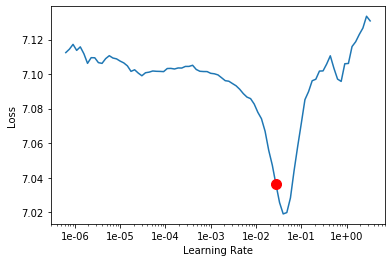

In [95]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [96]:
learn.fit_one_cycle(90, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.964059,6.738966,0.004006,06:16
1,6.394221,6.121084,0.004071,06:21
2,5.966828,5.799095,0.005040,06:21
3,5.772232,5.660472,0.006655,06:16
4,5.640481,5.542488,0.008982,06:20
5,5.542869,5.478506,0.010209,06:19
6,5.464374,5.449701,0.011049,06:20
7,5.394903,5.404255,0.012083,06:23
8,5.327145,5.358671,0.014991,06:20
9,5.230216,5.307104,0.018416,06:20


KeyboardInterrupt: 

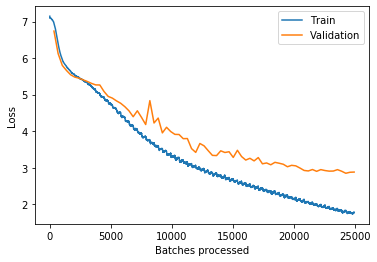

In [97]:
learn.recorder.plot_losses()

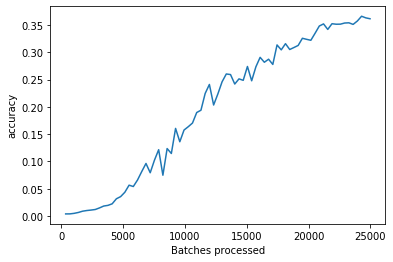

In [98]:
learn.recorder.plot_metrics()

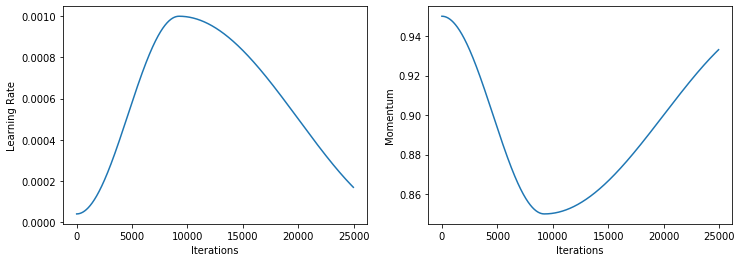

In [99]:
learn.recorder.plot_lr(show_moms=True)

In [102]:
learn.save('resnet50/adacos_se_xresnet50_ct_pg_128e073_190813')

In [78]:
learn.load('resnet50/adacos_se_xresnet50_ct_pg_128e073_190813');

### 128e090 Wasserstein Sinkhorn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.98E-03


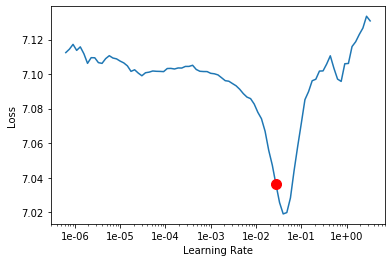

In [95]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [96]:
learn.fit_one_cycle(90, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.964059,6.738966,0.004006,06:16
1,6.394221,6.121084,0.004071,06:21
2,5.966828,5.799095,0.005040,06:21
3,5.772232,5.660472,0.006655,06:16
4,5.640481,5.542488,0.008982,06:20
5,5.542869,5.478506,0.010209,06:19
6,5.464374,5.449701,0.011049,06:20
7,5.394903,5.404255,0.012083,06:23
8,5.327145,5.358671,0.014991,06:20
9,5.230216,5.307104,0.018416,06:20


KeyboardInterrupt: 

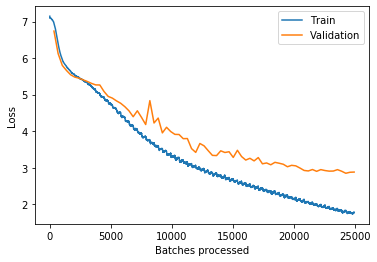

In [97]:
learn.recorder.plot_losses()

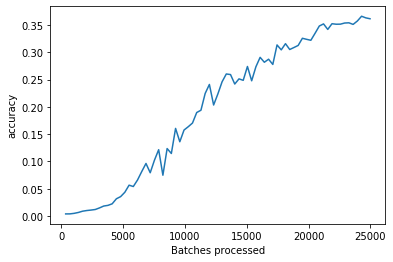

In [98]:
learn.recorder.plot_metrics()

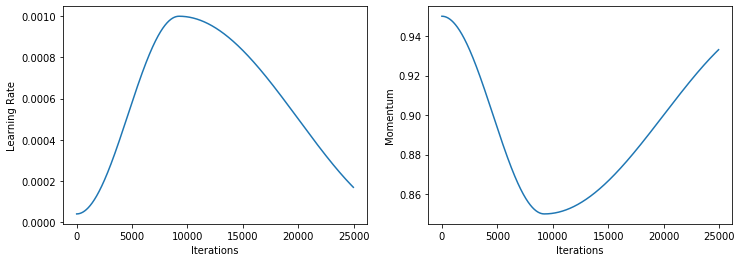

In [99]:
learn.recorder.plot_lr(show_moms=True)

In [102]:
learn.save('resnet50/adacos_se_xresnet50_ct_pg_128e073_190813')

In [78]:
learn.load('resnet50/adacos_se_xresnet50_ct_pg_128e073_190813');

### 128e090 CutMix

In [ ]:
learn.cutmix();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(90, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_190813')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_190813');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### 256e050

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(50, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050_190813')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050_190813');

### 256e050 CutMix

In [ ]:
learn.cutmix();

In [ ]:
# w CutMix
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(50, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050CM050_190814')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050CM050_190814');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(40, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050CM090_190814')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050CM090_190814');

### CutMix 1-Cycle #2

In [ ]:
learn.cutmix();

In [ ]:
# w CutMix
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(60, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('resnet50/adacos_se_xresnet_celltype_128e090-256e050CM110_190812')

In [ ]:
learn.load('resnet50/adacos_se_xresnet_celltype_128e090-256e050CM110_190812');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Custom Blend CutMix

In [ ]:
kwargs = {
    'size': .05, 
    'alpha': .2,
    'blend_type': 'zero', 
}

In [ ]:
learn.blend(**kwargs);

In [ ]:
learn.fit_one_cycle(4, 1e-3)

In [ ]:
%debug

In [ ]:
# Define transform function
tfm_fn = partial(blend, blend_type='cut', same_size=False)

#Define schedule parameters
sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a list of tuples
sch_iter = [(0., .3), (0., .7)]  # And a tuple with start and end iteration percentage
sch_func = [annealing_cos, partial(cosine_annealing, pct_start=.3)] # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

# Submission

## Classifcation

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [ ]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# check length
len(preds)

In [ ]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_cat})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with the same/not the same the prediction for both sites
idx = [] # indices with the same prediction
idx_notsame = [] # indices with not the same prediction
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    if i % 2:
        # distance from row 2 is 
        if pred == r[1]['sirna']:
            idx.append(r[0])
        else:
            #idx.append(r[0]) # always append idx until we come up with something better
            idx.append(idx_row_before)
            idx_notsame.append(idx_row_before) # get the first rows of the pairs that are not the same
    else:
        # save dist from row 1 for comparison in next iteration
        pred = r[1]['sirna']
        idx_row_before = r[0]

In [ ]:
len(idx), len(idx_notsame)

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_e080CM112_190805'
model = 'metriclearn_efficientnet_b3_e080CM112_190805'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


## Cosinus similarity

### Full single features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [92]:
# extended tfms w/o color_augmentation !!!
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75)

In [93]:
sz, bs = 256, 8*5

In [94]:
# VALID SPLIT (incl. tfms)
data = (ImageList6Dct.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6Dct.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [95]:
data.normalize([stats_mean, stats_var])

ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6Dct
Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6Dct
Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6Dct
Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256),Image6Dct (6, 256, 256)
y: EmptyLabelList
,,,,
Path: train

In [ ]:
#data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
#data.train_dl.dl.batch_sampler.drop_last = False
#
#data.valid_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.valid_ds)
#data.valid_dl.dl.batch_sampler.drop_last = False
#
## DOES WORK TOO FOR TEST DL ??? ??? (Or do we need to set the test dataset to the valid dataset?)
#data.test_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.test_ds)
#data.test_dl.dl.batch_sampler.drop_last = False

In [96]:
learn = Learner(data, adacos_se_xresnet50c)

In [97]:
learn.load('resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050CM050_190814');

In [120]:
#def get_feats(model, dataloader, cycles=1):
#    feats = []
#    targs = []
#    model.eval()
#    with torch.no_grad():
#        for i in range(cycles): # for TTA
#            for xb, yb in dataloader:
#                body_out = model.body(xb)
#                head_out = model.head(body_out)
#                feats.append(head_out.cpu())
#                targs.append(yb.cpu())
#    return feats, targs

In [98]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                xb_img, xb_ctint, xb_pgint = xb
                resnet_features = model.body1(xb_img)
                int_features = model.body2(xb_ctint, xb_pgint)
                features = torch.cat((resnet_features, int_features), dim=-1)
                out = model.head(features)
                feats.append(out.cpu())
                targs.append(yb.cpu())
    return feats, targs   

#### Train

In [99]:
feats, targs = get_feats(learn.model, learn.data.train_dl)#, cycles=3)

In [100]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [101]:
feats.shape, targs.shape

(torch.Size([57520, 512]), torch.Size([57520]))

In [102]:
np.save('pred/feats_train.npy', feats)
np.save('pred/targs_train.npy', targs)

#### Valid

In [103]:
feats, targs = get_feats(learn.model, learn.data.valid_dl)

In [104]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [105]:
feats.shape, feats.shape, targs.shape

(torch.Size([15476, 512]), torch.Size([15476, 512]), torch.Size([15476]))

In [106]:
np.save('pred/feats_valid.npy', feats)
np.save('pred/targs_valid.npy', targs)

#### Test

In [107]:
feats, targs = get_feats(learn.model, learn.data.test_dl)

In [108]:
del targs

In [109]:
feats = torch.cat(feats, dim=0)

In [110]:
feats.shape

torch.Size([39794, 512])

In [111]:
np.save('pred/feats_test.npy', feats)

### Multi-crop features

In [112]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [113]:
df_train['test'] = 0
df_train['path'] = 'train/'+df_train['path']

In [ ]:
df_train.head()

In [ ]:
# add dummy columns for test dataset
df_test['path'] = 'test/'+df_test['path']
df_test['test'] = 1
df_test['sirna'] = 1

In [ ]:
df_test.head()

In [106]:
df_train_test = pd.concat((df_train, df_test), axis=0, sort=False)

In [107]:
df_train_test.tail()

,path,experiment,sirna,multi,valid
19892,U2OS-05/Plate4/O19_s2,U2OS-05,NaN,NaN,NaN
19893,U2OS-05/Plate4/O20_s2,U2OS-05,NaN,NaN,NaN
19894,U2OS-05/Plate4/O21_s2,U2OS-05,NaN,NaN,NaN
19895,U2OS-05/Plate4/O22_s2,U2OS-05,NaN,NaN,NaN
19896,U2OS-05/Plate4/O23_s2,U2OS-05,NaN,NaN,NaN


In [ ]:
# reload for train and valid ds
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [ ]:
# test tfms switching for test ds
#tfms_switched = (tfms[1], tfms[0])
#
#data = (ImageList6D.from_df(df_train_test, path='.')
#                .split_from_df(col=-1)
#                .label_from_df(cols=-4)
#                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#                .databunch(bs=bs))

In [ ]:
#data.train_ds[0][0]

In [ ]:
#data.valid_ds[0][0]

In [ ]:
def get_dataset(row_pct, col_pct, is_test=False):
    # extended tfms
    tfms = get_transforms(do_flip=True, flip_vert=True, 
                          max_rotate=90.0, max_zoom=1.1, 
                          max_lighting=0.2, max_warp=0.2, 
                          p_affine=0.75, p_lighting=0.75, 
                          xtra_tfms=[color_augmentation()])
    
    # change "crop_pad" from get_transforms to "crop"
    tfms[0][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    tfms[1][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    
    # VALID SPLIT (incl. tfms)
    if is_test:
        #switch train with valid (= test) tfms!
        tfms_switched = (tfms[1], tfms[0])
        
        data = (ImageList6D.from_df(df_train_test, path='.')
                .split_from_df(col=-1)
                .label_from_df(cols=-4)
                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    else:
        data = (ImageList6D.from_df(df_train, path='train')
                .split_from_df(col=-1) # split_by_rand_pct()
                .label_from_df(cols=-3)
                #.add_test(ImageList6D.from_df(df_test, path='test'))
                .transform(tfms)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    
    data.normalize([tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
                    tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]);
    
    return data

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = model.body(xb)
                head_out = model.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
                
    feats = torch.cat(feats, dim=0)
    targs = torch.cat(targs, dim=0)
    
    return feats, targs

In [ ]:
def save_feats(feats, targs, crop, ds='train'):
    np.save(f'pred/feats_{ds}_crop{crop}.npy', feats)
    np.save(f'pred/targs_{ds}_crop{crop}.npy', targs)

In [ ]:
#https://docs.fast.ai/vision.transform.html#_crop
crop_pos = [[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
# get random crop pos
i = 2
crop_pos = [[uniform(0,1), uniform(0,1)] for i in range(2)]

In [ ]:
crop_pos

In [ ]:
# get the last three crop positions:
crop_pos = [[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
def get_crop_feats(model=learn.model, cycles=1, crop_pos=crop_pos):
    
    for i, (row_pct, col_pct) in enumerate(crop_pos):
        
        print('== crop#:', i,' of', len(crop_pos), '==')
        print('row_pct:', row_pct,', col_pct:', col_pct)
    
        data = get_dataset(row_pct, col_pct)
        
        # train
        print('= Start train dataset =')
        feats, targs = get_feats(model, data.train_dl)
        save_feats(feats, targs, i, ds='train')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish train dataset -')
        
        # valid
        print('= Start valid dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='valid')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish valid dataset -')
        
        # get test ds as valid ds for TTA
        data = get_dataset(row_pct, col_pct, is_test=True)
        
        # test
        print('= Start test dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='test')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish test dataset -')

In [ ]:
learn = Learner(data, adacos_efficientnet_b3)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_e080CM112_190805');

In [ ]:
get_crop_feats()

In [ ]:
#data = (ImageList6D.from_df(df_train_test, path='.')
#        .split_from_df(col=-1)
#        .label_from_df(cols=-4)
#        .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#        .databunch(bs=bs))

### Submission

In [116]:
# get the names
preds_names = learn.data.test_ds.x.items

In [117]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [118]:
preds_test = np.load('pred/preds_test.npy')
dist_test = np.load('pred/dist_test.npy')

In [119]:
len(preds_names), len(preds_test), len(dist_test)

(39794, 39794, 39794)

In [120]:
#preds_test

In [121]:
#dist_test

In [122]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_test, 'cossim': dist_test})

In [123]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [124]:
# get row indices with highest cosine similiarity
idx = []
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    #print(r)
    #print('i: ',i)
    #print('idx: ',r[0])
    #print(r[1]['cossim'])
    if i % 2:
        # distance from row 2 is 
        if dist < r[1]['cossim']:
            idx.append(r[0])
        else:
            idx.append(idx_row_before)
    else:
        # save dist from row 1 for comparison in next iteration
        dist = r[1]['cossim']
        idx_row_before = r[0]

In [125]:
idx[:5]

[19897, 19898, 2, 19900, 19901]

In [126]:
df_preds.sort_values('id_code').head(10)

,id_code_site,sirna,cossim,id_code
0,HEPG2-08_1_B03_s1,904,0.628884,HEPG2-08_1_B03
19897,HEPG2-08_1_B03_s2,240,0.644725,HEPG2-08_1_B03
19898,HEPG2-08_1_B04_s2,31,0.739770,HEPG2-08_1_B04
1,HEPG2-08_1_B04_s1,31,0.684911,HEPG2-08_1_B04
2,HEPG2-08_1_B05_s1,199,0.812841,HEPG2-08_1_B05
19899,HEPG2-08_1_B05_s2,137,0.621264,HEPG2-08_1_B05
3,HEPG2-08_1_B06_s1,1075,0.708103,HEPG2-08_1_B06
19900,HEPG2-08_1_B06_s2,1075,0.842791,HEPG2-08_1_B06
4,HEPG2-08_1_B07_s1,756,0.746316,HEPG2-08_1_B07
19901,HEPG2-08_1_B07_s2,728,0.793391,HEPG2-08_1_B07


In [127]:
#df_preds.loc[idx,['id_code','sirna']]

In [128]:
# 'resnet50/adacos_se_xresnet50_ct_pg_128e073CM090_256e050CM050_190814'
model = 'metriclearn_se_xresnet50_ct_pg_128e073CM090_256e050CM050_190814'

In [129]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [130]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 82.4k/82.4k [00:04<00:00, 18.5kB/s]
Successfully submitted to Recursion Cellular Image Classification

# Error analysis

In [ ]:
preds_correct = np.load('preds_valid_correct.npy')

In [ ]:
df_erros = pd.DataFrame({'id_code': preds_names, 'correct': preds_test})

In [ ]:
df_erros[df_errors['correct'] == False]

In [ ]:
# ERROR ANALYSIS !!!